In [ ]:
#default_exp transforms
from nbdev.showdoc import show_doc

# Weight Transforms

> This module defines mask transforms for weight generation.

In [ ]:
#export
import torch, cv2, numpy as np
import torch.nn.functional as F
from fastcore.transform import DisplayedTransform
from fastai.torch_core import TensorImage, TensorMask

In [ ]:
#hide
import matplotlib.pyplot as plt
from scipy import ndimage
from fastcore.all import *

In [ ]:
#hide
x, y = np.indices((540, 600))
x1, y1, x2, y2 = 180, 180, 41*7, 52*7
r1, r2 = 10*7.20, 20*7
mask_circle1 = (x - x1) ** 2 + (y - y1) ** 2 < r1 ** 2
mask_circle2 = (x - x2) ** 2 + (y - y2) ** 2 < r2 ** 2
mask = np.logical_or(mask_circle1, mask_circle2).astype(int)
inst_labels, _ = ndimage.measurements.label(mask)

def show(*args, cmap = 'binary_r'):
    figsize=(3*len(args),6)
    fig, ax = plt.subplots(1, ncols=len(args),figsize=figsize, squeeze=False)
    for i,x in enumerate(args):
        ax[0,i].imshow(x, cmap=cmap)
        ax[0,i].set_axis_off()
    plt.tight_layout()
    plt.show()

## Mask preprocessing

Supported segmentation mask types:

**Class labels**: pixel annotations of classes (e.g., 0 for background and 1...n for positive classes) <br>
**Instance labels**: pixel annotation of belonggig to different instance (e.g., 0 for background, 1 for first ROI, 2 for second ROI, etc.).

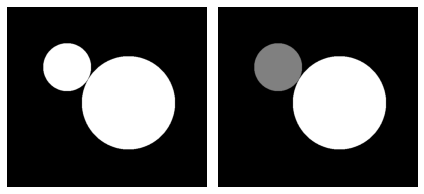

In [ ]:
show(mask, inst_labels)

The provided segmentation masks are preprocessed to 
- convert instance labels to class labels
- draw small ridges between touching instances (optional)

In [ ]:
#export
def preprocess_mask(clabels=None, instlabels=None, ignore=None, remove_overlap=True,
                     n_dims = 2, fbr=.1):
    "Calculates the weights from the given mask (classlabels `clabels` or `instlabels`)."

    assert not (clabels is None and instlabels is None), "Provide either clabels or instlabels"

    # If no classlabels are given treat the problem as binary segmentation
    # ==> Create a new array assigning class 1 (foreground) to each instance
    if clabels is None:
        clabels = (instlabels > 0).astype(int)

    if remove_overlap:
        # Initialize label and weights arrays with background
        labels = np.zeros_like(clabels)
        classes = np.unique(clabels)[1:]
        # If no instance labels are given, generate them now
        if instlabels is None:
            # Creating instance labels from mask
            instlabels = np.zeros_like(clabels)
            nextInstance = 1
            for c in classes:
                #comps2, nInstances2 = ndimage.measurements.label(clabels == c)
                nInstances, comps = cv2.connectedComponents((clabels[:] == c).astype('uint8'), connectivity=4)
                nInstances -=1
                instlabels[comps > 0] = comps[comps > 0] + nextInstance
                nextInstance += nInstances

        for c in classes:
            # Extract all instance labels of class c
            il = (instlabels * (clabels[:] == c)).astype(np.int16)
            instances = np.unique(il)[1:]

            # Generate background ridges between touching instances
            # of that class, avoid overlapping instances
            dil = cv2.morphologyEx(il, cv2.MORPH_CLOSE, kernel=np.ones((3,) * n_dims))
            overlap_cand = np.unique(np.where(dil!=il, dil, 0))        
            labels[np.isin(il, overlap_cand, invert=True)] = c

            for instance in overlap_cand[1:]:
                objectMaskDil = cv2.dilate((labels == c).astype('uint8'), kernel=np.ones((3,) * n_dims),iterations = 1)
                labels[(instlabels == instance) & (objectMaskDil == 0)] = c
    else:
        labels = clabels        

    return labels#.astype(np.int32)

Arguments in `preprocess_masks`:
- `clabels`: class labels (segmentation mask), 
- `instlabels`: instance labels (segmentation mask), 
- `n_dims` (int) = number of classes for `clabels` 

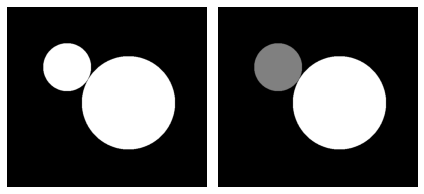

Zoom in on borders:


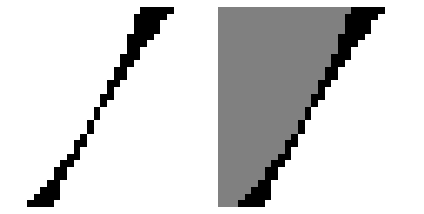

In [ ]:
tst1 = preprocess_mask(mask, remove_overlap=False)
tst2 = preprocess_mask(inst_labels, instlabels=True)
show(tst1,tst2)
ind = (slice(200,230), slice(230,260))
print('Zoom in on borders:')
show(tst1[ind], tst2[ind])

**Effective sampling**: Probability density function (PDF)

In [ ]:
#export
def create_pdf(labels, ignore=None, fbr=.1, scale=512):
    'Creates a cumulated probability density function (PDF) for weighted sampling '
    
    pdf = (labels[:] > 0) + (labels[:] == 0) * fbr

    # Set weight and sampling probability for ignored regions to 0
    if ignore is not None:
        pdf[ignore] = 0.0
        
    if scale:
        if pdf.shape[0]>scale:
            scale_w = int((pdf.shape[1]/pdf.shape[0])*scale)
            pdf = cv2.resize(pdf, dsize=(scale_w, scale), interpolation=cv2.INTER_CUBIC)
    
    return np.cumsum(pdf/np.sum(pdf))

- `labels`: preprocessed class labels (segmentation mask)
- `ignore`: ignored reagions,
- `fbr` (float): foreground_background_ratio to define the sampling PDF
- `scale` (bool): limit size of pdf

In [ ]:
pdf = create_pdf(tst2, scale=None)
test_eq(pdf.shape[0],tst2.shape[0]*tst2.shape[1])
scale = 512
pdf = create_pdf(tst2, scale=scale)
test_close(pdf.max(),1)

Random center

In [ ]:
#export
def random_center(pdf, orig_shape, scale=512):
    'Sample random center using PDF'
    scale_y = int((orig_shape[1]/orig_shape[0])*scale)
    cx, cy = np.unravel_index(np.argmax(pdf > np.random.random()), (scale,scale_y))
    cx = int(cx*orig_shape[0]/scale)
    cy = int(cy*orig_shape[1]/scale_y)
    return cx, cy

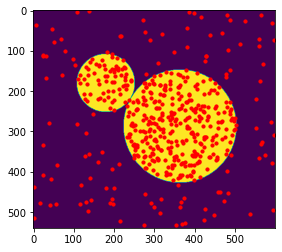

In [ ]:
centers = [random_center(pdf, mask.shape) for _ in range(int(5e+2))]
plt.imshow(mask)
xs = [x[1] for x in centers]
ys = [x[0] for x in centers]
plt.scatter(x=xs, y=ys, c='r', s=10)
plt.show()

## Mask Weights

We calculate the weight for the weighted softmax cross entropy loss from the given mask (classlabels).

**!! Attention: calculate_weights is not used for training anymore!!** See real-time weight calculation

In [ ]:
#export
def calculate_weights(clabels=None, instlabels=None, ignore=None,
                      n_dims = 2, bws=10, fds=10, bwf=10, fbr=.1):
    """
    Calculates the weights from the given mask (classlabels `clabels` or `instlabels`).
    """

    assert not (clabels is None and instlabels is None), "Provide either clabels or instlabels"

    # If no classlabels are given treat the problem as binary segmentation
    # ==> Create a new array assigning class 1 (foreground) to each instance
    if clabels is None:
        clabels = (instlabels > 0).astype(int)

    # Initialize label and weights arrays with background
    labels = np.zeros_like(clabels)
    wghts = fbr * np.ones_like(clabels)
    frgrd_dist = np.zeros_like(clabels, dtype='float32')
    classes = np.unique(clabels)[1:]
    
    #assert len(classes)==clabels.max(), "Provide consecutive classes, e.g. pixel label 1 and 2 for two classes"

    # If no instance labels are given, generate them now
    if instlabels is None:
        # Creating instance labels from mask
        instlabels = np.zeros_like(clabels)
        nextInstance = 1
        for c in classes:
            #comps2, nInstances2 = ndimage.measurements.label(clabels == c)
            nInstances, comps = cv2.connectedComponents((clabels == c).astype('uint8'), connectivity=4)
            nInstances -=1
            instlabels[comps > 0] = comps[comps > 0] + nextInstance
            nextInstance += nInstances

    for c in classes:
        # Extract all instance labels of class c
        il = (instlabels * (clabels == c)).astype(np.int16)
        instances = np.unique(il)[1:]

        # Generate background ridges between touching instances
        # of that class, avoid overlapping instances
        dil = cv2.morphologyEx(il, cv2.MORPH_CLOSE, kernel=np.ones((3,) * n_dims))
        overlap_cand = np.unique(np.where(dil!=il, dil, 0))        
        labels[np.isin(il, overlap_cand, invert=True)] = c
    
        for instance in overlap_cand[1:]:
            objectMaskDil = cv2.dilate((labels == c).astype('uint8'), kernel=np.ones((3,) * n_dims),iterations = 1)
            labels[(instlabels == instance) & (objectMaskDil == 0)] = c

        # Generate weights
        min1dist = 1e10 * np.ones(labels.shape)
        min2dist = 1e10 * np.ones(labels.shape)
        for instance in instances:
            #dt2 = ndimage.morphology.distance_transform_edt(instlabels != instance)
            dt = cv2.distanceTransform((instlabels != instance).astype('uint8'), cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
            frgrd_dist += np.exp(-dt ** 2 / (2*fds ** 2))
            min2dist = np.minimum(min2dist, dt)
            newMin1 = np.minimum(min1dist, min2dist)
            newMin2 = np.maximum(min1dist, min2dist)
            min1dist = newMin1
            min2dist = newMin2
        wghts += bwf * np.exp(-(min1dist + min2dist) ** 2 / (2*bws ** 2))

    # Set weight for distance to the closest foreground object
    wghts[labels == 0] += (1-fbr)*frgrd_dist[labels == 0]
    # Set foreground weights to 1
    wghts[labels > 0] = 1
    pdf = (labels > 0) + (labels == 0) * fbr

    # Set weight and sampling probability for ignored regions to 0
    if ignore is not None:
        wghts[ignore] = 0
        pdf[ignore] = 0

    return (labels.astype(np.int32),
            wghts.astype(np.float32),
            pdf.astype(np.float32))

Arguments in `calculate_weights`:
- `clabels`: class labels (segmentation mask), 
- `instlabels`: instance labels (segmentation mask), 
- `ignore`: ignored reagions,
- `n_dims` (int) = number of classes for `clabels` 
- `bws` (float): border_weight_sigma in pixel
- `fds` (float): foreground_dist_sigma in pixel
- `bwf` (float): border_weight_factor 
- `fbr` (float): foreground_background_ratio

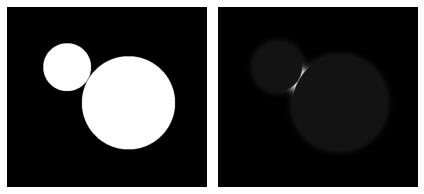

In [ ]:
labels, weights, _ =  calculate_weights(clabels=mask)
titles = ['Labels (Mask)', 'Weights', 'PDF', ]
show(labels, weights)

Plot different weight parameters (`foreground_dist_sigma_px`, `border_weight_factor`)

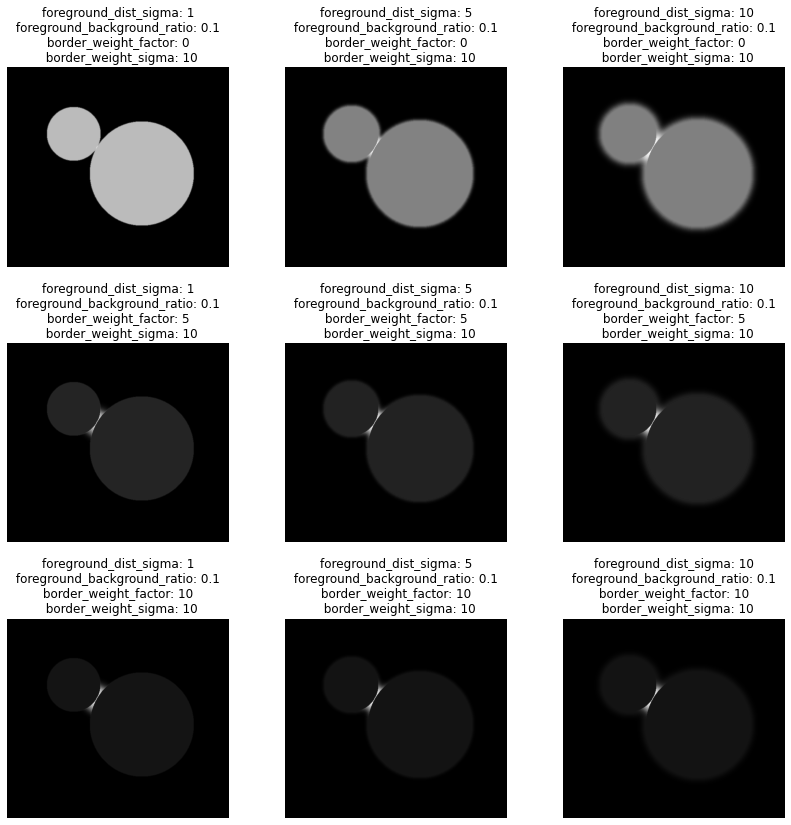

In [ ]:
#hide_input
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,12))
i = 0 
for fds in [1,5,10]:
    j = 0
    for bwf in [0, 5, 10]:        
        _, w, _ = calculate_weights(clabels=mask, fds=fds, bwf=bwf)
        axes[j,i].imshow(w, cmap='binary_r')
        axes[j,i].set_axis_off()
        axes[j,i].set_title(f'foreground_dist_sigma: {fds}\n foreground_background_ratio: {.1} \n border_weight_factor: {bwf} \n  border_weight_sigma: {10}')
        j+=1
    i += 1
plt.tight_layout(pad=3.0)
plt.show()

### Real-time weight calculation

To efficiently calculate the mask weights for training we leverage the *LogConv* apporach for fast convolutional distance transform based on this [paper](https://ieeexplore.ieee.org/abstract/document/8686167): Karam, Christina, Kenjiro Sugimoto, and Keigo Hirakawa. "Fast convolutional distance transform." IEEE Signal Processing Letters 26.6 (2019): 853-857.

Our implementation in Pytorch leverages
- Separable convolutions 
- GPU accelaration

We use a lambda=0.35 and a kernel size of 73.

In [ ]:
#export
def lambda_kernel(ks, lmbda):
    x = torch.arange(ks, dtype=torch.float) - ks // 2 
    if ks % 2 == 0: x = x + 0.5
    d = torch.sqrt(x**2)
    return torch.exp(-d/lmbda)

In [ ]:
test_eq(lambda_kernel(3, 0.35)[1],1)

In [ ]:
#export
class SeparableConv2D(torch.nn.Module):
    'Apply kernel on a 2d Tensor as a sequence of 1-D convolution filters.'
    def __init__(self, lmbda, channels, ks=73, padding_mode='constant'):
        super().__init__()
        
        self.channels = channels # assuming same 2D dimensions for H/W         
        ks = ks if ks % 2 == 1 else ks+1
        self.padding = ((ks-1)//2, (ks-(ks%2))//2)
        self.padding_mode = padding_mode
        kernel = lambda_kernel(ks, lmbda)
        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, -1)
        kernel = kernel.repeat(channels, 1, 1)
        self.weight = kernel
    
    def forward(self, inp):
        'Apply 1d gaussian filter to 2d input.'
        # assuming shape [ROIS, H, W]
        weight = self.weight.to(inp)
        for _ in range(2):
            inp = F.conv1d(F.pad(inp, self.padding, mode=self.padding_mode), weight=weight, groups=self.channels)
            inp = torch.transpose(inp, 1,2)
        return inp#.contiguous()

In [ ]:
inp1 = torch.eye(3)[inst_labels][...,1:]
inp1 = inp1.permute(2,0,1)
tst = SeparableConv2D(0.35, channels=inp1.size(-1))
out = tst(inp1)
show(out[0], out[1])

RuntimeError: Given groups=600, weight of size [600, 1, 73], expected input[2, 540, 672] to have 600 channels, but got 540 channels instead

Single item version for CPU from input shape [ROIS, H, W]

In [ ]:
#export
class WeightTransformSingle(DisplayedTransform):
    def __init__(self, channels, bws=10, fds=10, bwf=1, fbr=.1, lmbda=0.35, ks=73):
        self.bws, self.fds, self.bwf, self.fbr= bws, fds, bwf, fbr
        self.channels, self.lmbda = channels, lmbda
        self.filter = SeparableConv2D(self.lmbda, channels, ks=ks)
        print('Using real-time weight calculation.')
    
    def _distance_transform(self, x):
        'Fast convolutional distance transform'
        x = self.filter(x)
        return -self.lmbda*torch.log(x)
        
    def encodes(self, x:torch.Tensor): 
        #if isinstance(x, TensorImage) or isinstance(x, TensorMask): return x
        
        labels = (torch.sum(x, dim=0)>0)
        wghts = self.fbr * torch.ones((self.channels,)*2).to(x)
        if x.size(0)==0: return wghts
        dt = self._distance_transform(x)
        
        # Foreground_dist
        fd = torch.sum(torch.exp(-dt**2/(2*self.fds**2)), dim=0) 
        wghts[labels == 0] += (1-self.fbr)*fd[labels == 0]
        
        # Border Weights
        bw_max = torch.max(dt, dim=0)[0]
        bw_min = torch.min(dt, dim=0)[0]
        wghts += self.bwf * torch.exp(-(bw_max + bw_min)**2/ (2*self.bws ** 2))
        
        # Set foreground weights to 1
        wghts[labels > 0] = 1. 
        return wghts

In [ ]:
tst = WeightTransformSingle(channels=inp1.size(-1))
out = tst(inp1)
show(mask>0, mask, out)

Batch version for GPU transforms from instance labels with shape [batch, H, W] 

In [ ]:
#export
class WeightTransform(WeightTransformSingle):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def encodes(self, b:torch.Tensor): 
        if isinstance(b, TensorImage) or isinstance(b, TensorMask): return b
        w_ll = []
        for x in b:
            x = (torch.eye(int(x.max()+1))[x.type(torch.long)][...,1:]).to(x)
            x = x.permute(2,0,1)
            labels = (torch.sum(x, dim=0)>0)
            wghts = self.fbr * torch.ones((self.channels,)*2).to(x)
            if x.size(0)>0: 
                dt = self._distance_transform(x)
                
                # Foreground_dist
                fd = torch.sum(torch.exp(-dt**2/(2*self.fds**2)), dim=0) 
                wghts[labels == 0] += (1-self.fbr)*fd[labels == 0]
                
                # Border Weights
                bw_max = torch.max(dt, dim=0)[0]
                bw_min = torch.min(dt, dim=0)[0]
                wghts += self.bwf * torch.exp(-(bw_max + bw_min)**2/ (2*self.bws ** 2))
                
                # Set foreground weights to 1
                wghts[labels > 0] = 1. 
            w_ll.append(wghts)
        #assert x.device==torch.device(type='cpu')
        return torch.stack(w_ll).to(x)

In [ ]:
inp2 = torch.Tensor(inst_labels)#.cuda()
inp2 = inp2.view(1, *inp2.shape)
tst = WeightTransform(channels=inp2.size(-1))
out = tst(inp2)
show(mask>0, mask, out[0])

## Export -

In [ ]:
#hide
from nbdev.export import *
notebook2script()